In [1]:
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
features = pd.read_pickle('./data/features_test.pkl')
stock_data = pd.read_csv('./data/stock_data_test.csv', index_col='Unnamed: 0')

In [3]:
display(features)
display(stock_data)

{'4584.T':           feat_1      feat_2     feat_3      feat_4      feat_5      feat_6  \
 180   734.689087  123.499207  30.843113 -345.803986  433.608459 -449.363556   
 181   634.747009  103.663925  28.473894 -294.388885  373.312225 -384.783264   
 182   676.864746  112.292336  32.621391 -316.591156  401.190735 -412.538086   
 183   694.850098  118.005768  34.235714 -324.470490  412.803833 -425.951752   
 184   684.634338  116.040680  32.078613 -317.571198  406.474396 -417.737030   
 ...          ...         ...        ...         ...         ...         ...   
 1294  223.451508   39.885864  11.101674 -102.470436  138.206482 -143.450790   
 1295  230.035980   42.742805   9.579368 -105.303726  140.051514 -141.415268   
 1296  226.375488   37.585320  12.369206 -103.315849  140.573196 -144.255249   
 1297  230.569122   39.036400  13.432136 -105.590363  142.691833 -142.796387   
 1298  226.544662   41.507702  13.038601 -102.488571  138.436844 -143.210434   
 
           feat_7      feat_

,4584.T,1557.T,8789.T,1893.T,MSFT
180,661.0,28860.0,137.0,533.62700,11123.248
181,708.0,29190.0,140.0,543.87270,10875.842
182,730.0,29370.0,145.0,529.35803,10690.548
183,718.0,29630.0,144.0,547.28790,11058.452
184,732.0,29800.0,141.0,552.41077,11266.821
...,...,...,...,...,...
1294,243.0,55640.0,80.0,680.00000,41467.410
1295,241.0,55680.0,79.0,681.00000,42251.793
1296,244.0,55600.0,69.0,675.00000,41581.720
1297,241.0,55650.0,68.0,678.00000,41555.848


In [4]:
from ray.tune import register_env

# 環境クラスのインポート
from gym_stock_trading_env import StockTradingEnv

# Define a function to create the environment
def create_stock_trading_env(_):
    env = StockTradingEnv(stock_data, features)
    return env

# Register the environment
env_name = "stock_trading_env"
register_env(env_name, create_stock_trading_env)

c:\Users\rodin\work\stock_trade\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import os
import ray
from ray.rllib.algorithms.ppo import PPOConfig
from collections import defaultdict

# Initialize Ray in local mode
ray.init(ignore_reinit_error=True)

# Create the environment
env = StockTradingEnv(stock_data, features)

# Create PPO agent
ppo_config = PPOConfig()
ppo_config["vf_loss_coeff"] = 0.01 # default : False
ppo_config["entropy_coeff_schedule"] = [(0, 0.1), (3000, 0.001)]  # default : None
# ppo_config["entropy_coeff"] = 0.05 # default : 0.01
# ppo_config["lr"] = 0.00002 # default : 5e-5

ppo_agent = ppo_config.environment(env=env_name)
ppo_agent = ppo_config.build()

# Track rewards
rewards = []

# Train the agents
num_iterations = 3000

for i in range(num_iterations):
    ppo_result = ppo_agent.train()
    print(f"Iteration {i + 1}:")
    print(f"PPO: episode_reward_mean={ppo_result['episode_reward_mean']}")
    
    # Record the reward
    rewards.append(ppo_result['episode_reward_mean'])

2023-05-23 21:22:50,430	INFO worker.py:1625 -- Started a local Ray instance.
2023-05-23 21:22:51,879	INFO algorithm.py:527 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(RolloutWorker pid=23656) 2023-05-23 21:22:54,699	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
2023-05-23 21:22:54,851	WARNING util.py:67 -- Install gputil for GPU system monitoring.


(RolloutWorker pid=23656) 4
Iteration 1:
PPO: episode_reward_mean=-1.2535735923922453
(RolloutWorker pid=23656) 2 [repeated 4079x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
Iteration 2:
PPO: episode_reward_mean=-1.146173091680082
(RolloutWorker pid=23656) 2 [repeated 3993x across cluster]
Iteration 3:
PPO: episode_reward_mean=-0.9727827652192576
(RolloutWorker pid=23656) 3 [repeated 3974x across cluster]
Iteration 4:
PPO: episode_reward_mean=-0.6942161905053519
(RolloutWorker pid=23656) 2 [repeated 4037x across cluster]
Iteration 5:
PPO: episode_reward_mean=-0.5536313975832127
(RolloutWorker pid=23656) 3 [repeated 4005x across cluster]
Iteration 6:
PPO: episode_reward_mean=-0.41930596934836367
(RolloutWorker pid=23656) 4 [repeated 3974x across cluster]
Iteration 7:
PPO: episode_reward_mean=-0.3913048550834837
(RolloutWor

KeyboardInterrupt: 

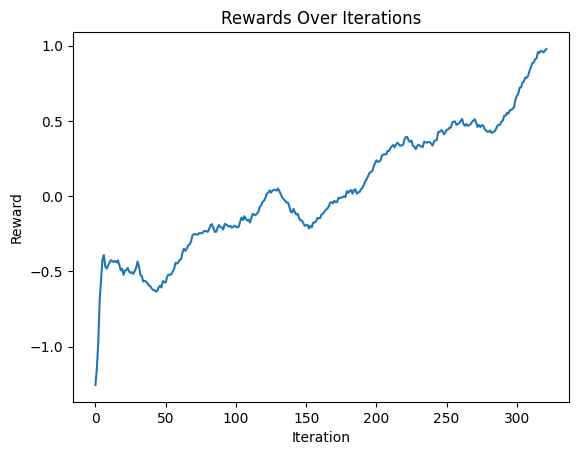

In [6]:
modelpath = ppo_agent.save('./model')
os.makedirs(modelpath+'/fig', exist_ok=True)

# Plot rewards
plt.plot(rewards)
plt.title("Rewards Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Reward")
plt.savefig(modelpath+'/fig/reward_over_iterations.png')
plt.show()

2023-05-23 22:29:17,872	INFO worker.py:1454 -- Calling ray.init() again after it has already been called.
(RolloutWorker pid=7520) 2023-05-23 22:29:20,838	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
2023-05-23 22:29:20,888	WARNING util.py:67 -- Install gputil for GPU system monitoring.
2023-05-23 22:29:20,902	WARNING checkpoints.py:109 -- No `rllib_checkpoint.json` file found in checkpoint directory model\checkpoint_000322\.! Trying to extract checkpoint info from other files found in that dir.
2023-05-23 22:29:20,937	INFO trainable.py:913 -- Restored on 127.0.0.1 from checkpoint: model\checkpoint_000322
2023-05-23 22:29:20,937	INFO trainable.py:922 -- Current state after restoring: {'_iteration': 322, '_timesteps_total': None, '_time_total': 3955.950350999832, '_episodes_total': 1152}


(RolloutWorker pid=12528) 4 [repeated 3985x across cluster]

Evaluating trained agents:
3
2
3
1
2
2
1
2
3
4
2
1
3
3
2
4
2
3
3
3
3
1
2
2
2
3
2
3
2
1
2
2
3
3
0
1
1
1
3
1
1
2
2
3
3
2
3
2
2
1
2
4
1
1
3
2
1
2
3
2
2
2
3
3
2
2
1
3
2
4
2
2
2
2
2
2
2
3
2
1
2
2
1
3
1
3
2
1
3
2
1
1
1
1
1
1
1
2
3
0
2
2
1
1
2
3
3
2
1
3
2
2
0
2
3
2
3
1
2
1
2
2
1
1
1
2
3
2
3
4
2
3
2
3
3
3
3
0
2
3
2
1
2
2
1
4
2
3
3
3
1
2
2
1
2
3
3
2
2
2
3
3
2
1
3
3
2
4
2
0
2
2
1
1
2
4
1
1
2
1
1
4
2
3
3
3
2
0
3
2
2
1
2
1
2
3
3
1
1
1
3
1
4
2
2
2
2
1
0
0
2
4
2
2
1
1
3
3
4
1
2
4
3
1
2
2
3
1
2
0
3
2
1
3
3
1
2
2
4
3
2
3
2
2
3
2
2
1
2
3
2
1
4
2
3
2
3
3
3
1
3
2
1
2
3
1
3
2
2
4
3
3
2
3
4
4
1
3
3
2
1
1
3
4
2
4
3
2
3
3
1
2
1
2
3
1
2
4
5
3
3
3
3
2
3
1
2
3
1
2
2
1
3
4
2
3
1
1
1
3
1
2
4
2
2
2
2
2
1
2
1
1
1
2
0
3
2
4
3
3
0
3
2
1
1
2
2
2
2
1
3
3
3
2
4
3
3
3
4
0
1
1
2
1
3
1
2
2
0
2
3
2
2
1
4
3
3
2
3
2
3
2
3
2
2
2
2
3
2
4
3
2
2
3
4
3
5
2
2
2
3
4
2
3
3
0
3
0
1
2
3
3
2
1
1
1
2
1
2
2
2
1
3
1
2
1
3
2
2
2
2
2
4
3
1
4
3
2
2
2
3
3
1
3
0
2
3
1
0
2
4
2
3
1
2
2


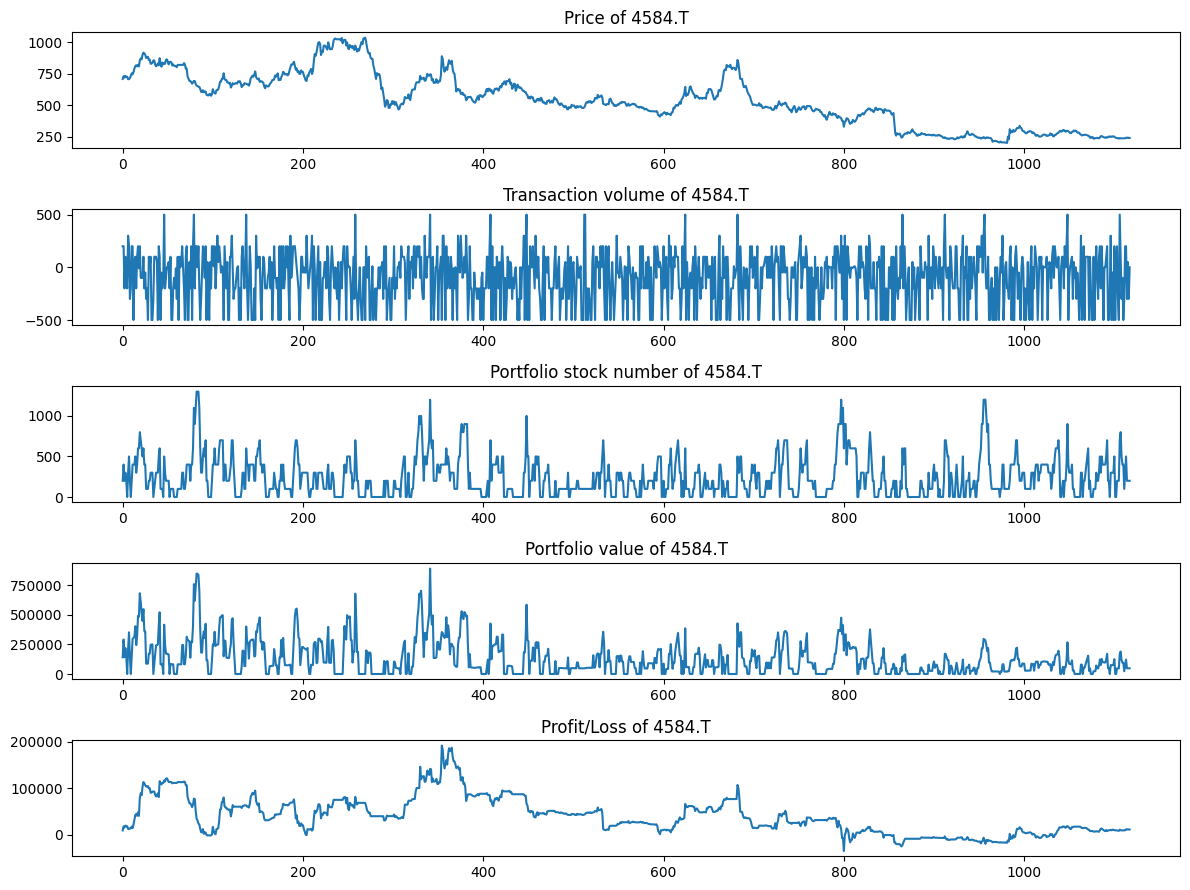

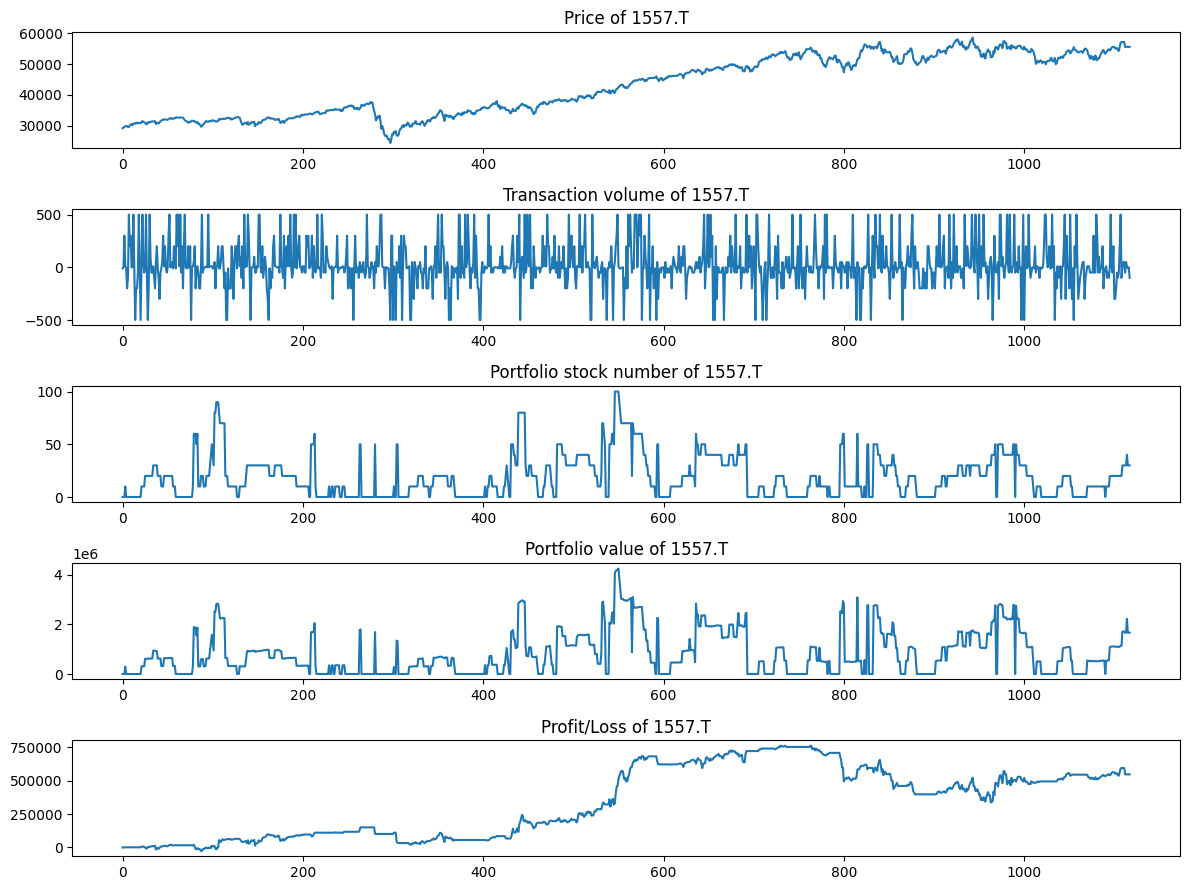

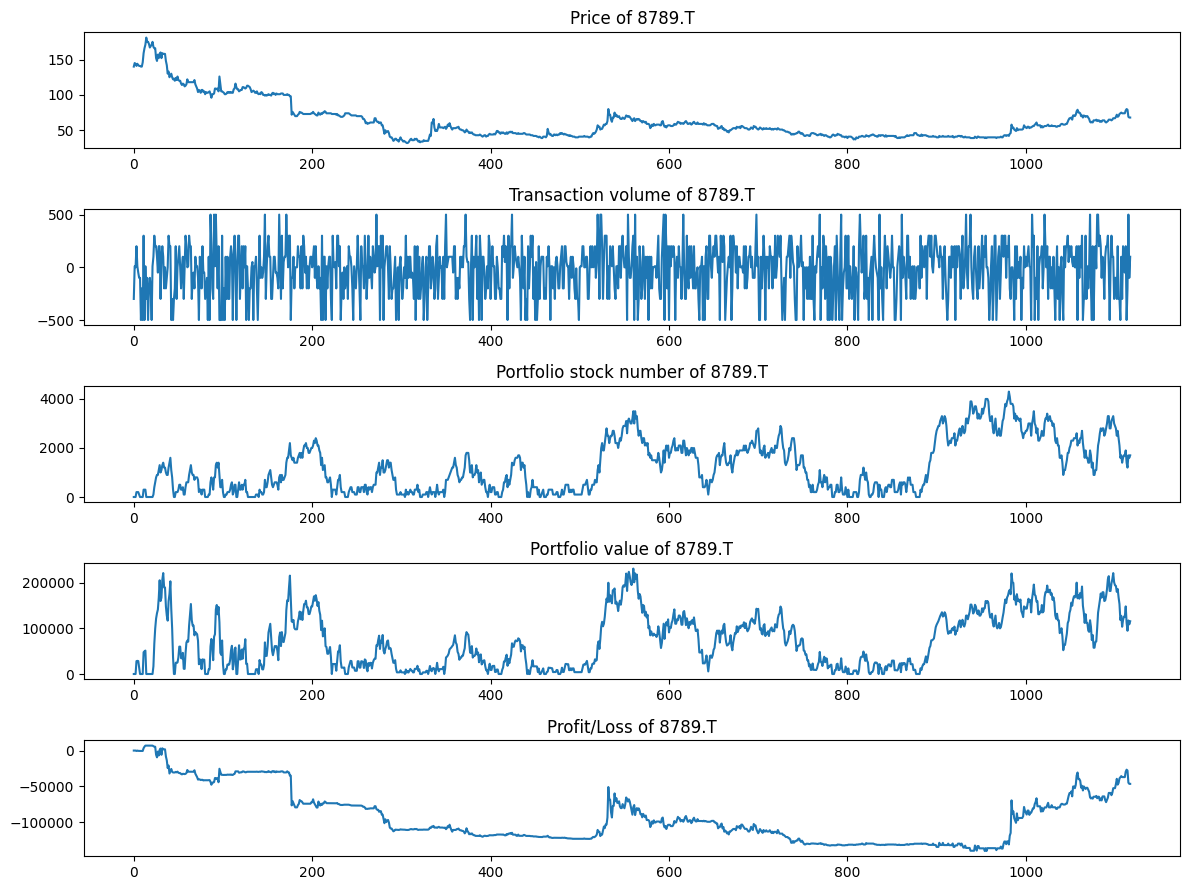

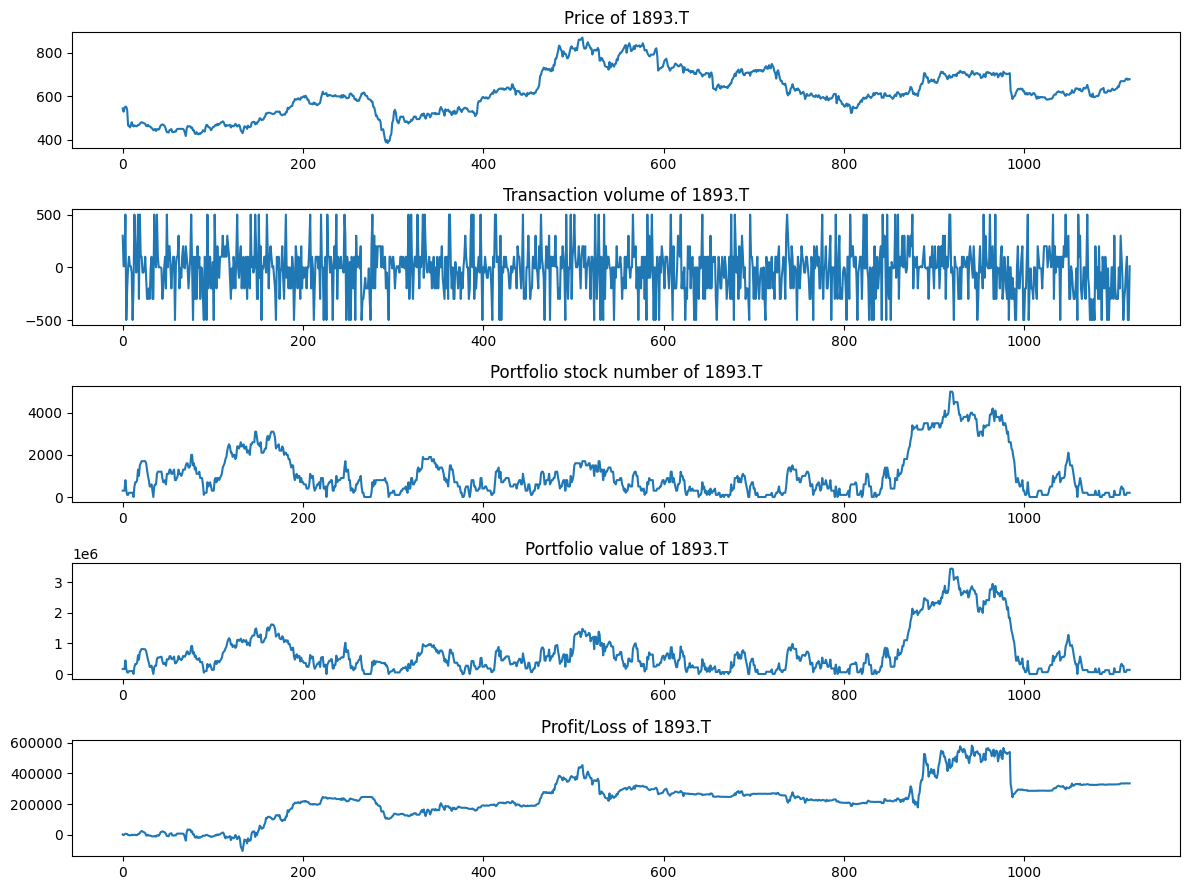

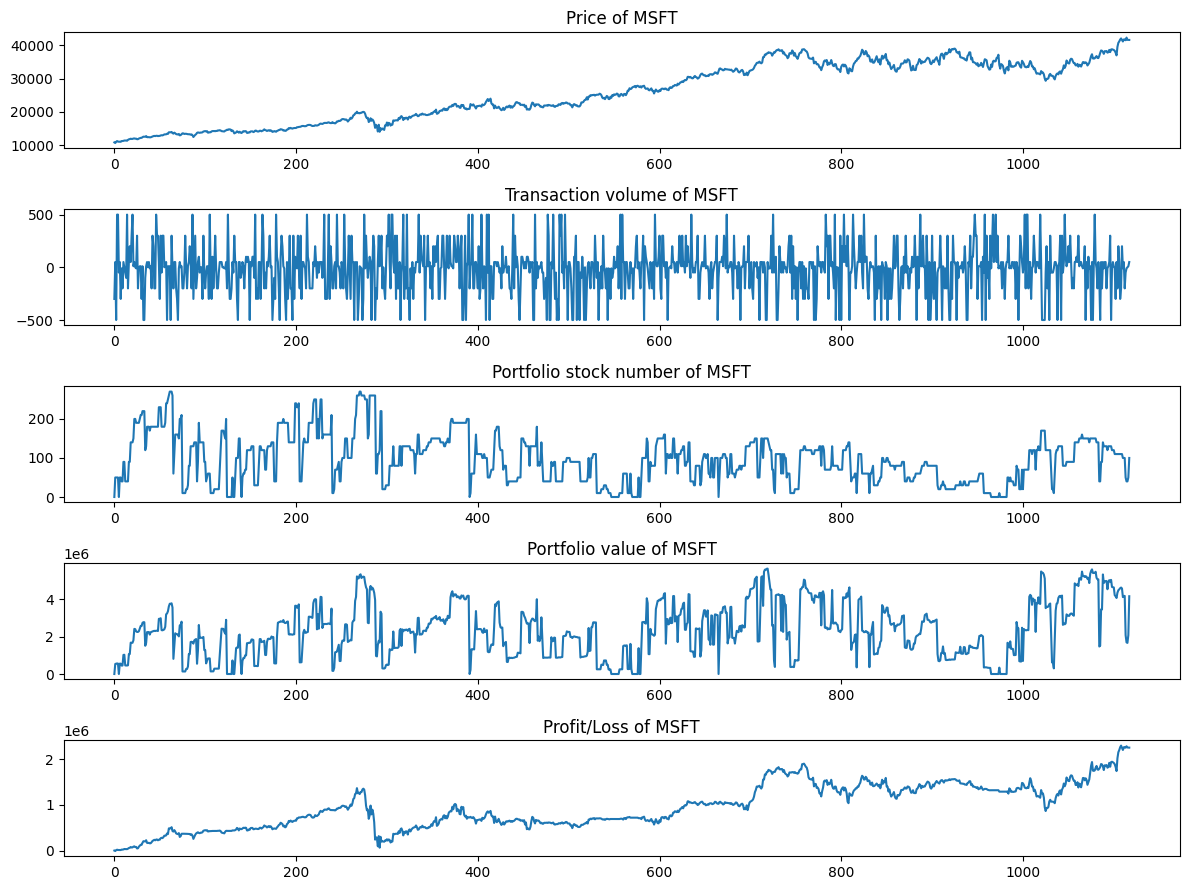

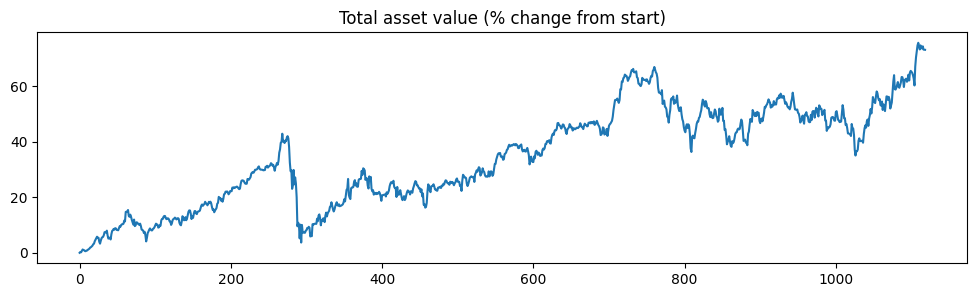

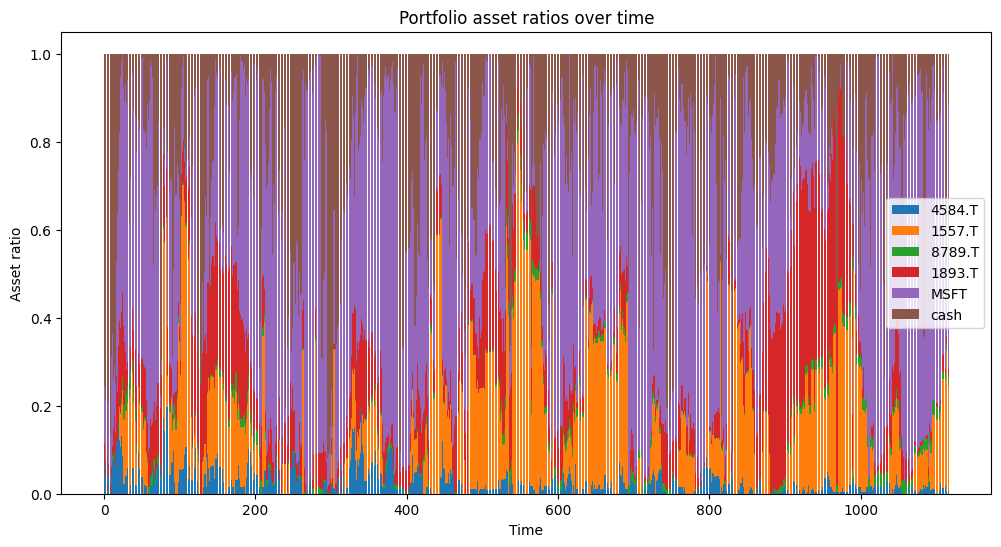

Total value percentage change: 73.04157780713935
PPO: 4584.T profit/loss=11197.034999997442
PPO: 1557.T profit/loss=547040.4899999939
PPO: 8789.T profit/loss=-46588.820000000735
PPO: 1893.T profit/loss=334959.8030422954
PPO: MSFT profit/loss=2255921.8359024837
(RolloutWorker pid=7520) 3


In [7]:
def evaluate(agent, env):
    obs, info = env.reset(seed=42)
    terminated = False

    # Initialize data tracking
    profit_loss = defaultdict(float)
    total_profit_loss = defaultdict(float)
    stock_prices = defaultdict(list)
    transaction_volumes = defaultdict(list)
    portfolio_values = defaultdict(list)
    portfolio_stock_number = defaultdict(list)
    profit_loss_values = defaultdict(list)
    total_values = []

    # Calculate the starting portfolio value
    stocks = env.stock_data.columns
    total_value_start = env.cash + sum(env.positions[stock] * env.stock_data.loc[env.current_step, stock] for stock in stocks)
    total_values.append(total_value_start)
    portfolio_ratios = {stock: [] for stock in stocks}
    portfolio_ratios["cash"] = []

    while not terminated:
        # action = agent.compute_action(obs)
        action = agent.compute_single_action(obs, exploit=True)  # force deterministic actions
        obs, reward, terminated, _, info = env.step(action)

        # Update the profit/loss for each stock
        for i, stock in enumerate(stocks):
            stock_prices[stock].append(env.stock_data.loc[env.current_step, stock])
            transaction_volumes[stock].append(env.shares_amounts[action[i]])
            portfolio_stock_number[stock].append(env.positions[stock])
            current_value = env.positions[stock] * env.stock_data.loc[env.current_step, stock]
            portfolio_values[stock].append(current_value)
            cost = info.get(stock, {}).get('cost', 0)
            sold_value = info.get(stock, {}).get('sell_value', 0)
            profit_loss[stock] += sold_value - cost
            total_profit_loss[stock] = profit_loss[stock] + current_value
            profit_loss_values[stock].append(total_profit_loss[stock])
            
        # Update portfolio ratios
        total_value = env.cash + sum(env.positions[stock] * env.stock_data.loc[env.current_step, stock] for stock in stocks)
        for stock in stocks:
            portfolio_ratios[stock].append(portfolio_values[stock][-1] / total_value)
        portfolio_ratios["cash"].append(env.cash / total_value)


        total_value_end = env.cash + sum(env.positions[stock] * env.stock_data.loc[env.current_step, stock] for stock in stocks)
        total_values.append(total_value_end)

    # Calculate total value percentage change
    total_value_percentage_change = ((total_value_end - total_value_start) / total_value_start) * 100
    total_values_percentage = [(value / total_value_start - 1) * 100 for value in total_values]
    
    # Plot data
    for stock in stocks:
        plt.figure(figsize=(12, 9))

        plt.subplot(511)
        plt.plot(stock_prices[stock])
        plt.title(f"Price of {stock}")

        plt.subplot(512)
        plt.plot(transaction_volumes[stock])
        plt.title(f"Transaction volume of {stock}")
        
        plt.subplot(513)
        plt.plot(portfolio_stock_number[stock])
        plt.title(f"Portfolio stock number of {stock}")

        plt.subplot(514)
        plt.plot(portfolio_values[stock])
        plt.title(f"Portfolio value of {stock}")

        plt.subplot(515)
        plt.plot(profit_loss_values[stock])
        plt.title(f"Profit/Loss of {stock}")

        plt.tight_layout()
        plt.savefig(modelpath+f'/fig/{stock}_result.png')
        plt.show()

    plt.figure(figsize=(12, 3))
    plt.plot(total_values_percentage)
    plt.title("Total asset value (% change from start)")
    plt.savefig(modelpath+'/fig/asset_transition.png')
    plt.show()
    
    # Plot portfolio ratios
    plt.figure(figsize=(12, 6))

    bar_width = 0.85
    bar_l = [i+1 for i in range(len(portfolio_ratios['cash']))] 
    tick_pos = [i+(bar_width/2) for i in bar_l]

    # Create a total ratio for stacking
    total_ratio = [0] * len(portfolio_ratios['cash'])

    for stock, ratios in portfolio_ratios.items():
        plt.bar(bar_l, ratios, bottom=total_ratio, label=stock, width=bar_width)
        total_ratio = [i+j for i,j in zip(total_ratio, ratios)]

    # Here we set the x-ticks to only include every nth tick to prevent crowding.
    n = 200  # the number of steps between each tick
    plt.xticks(tick_pos[::n], range(len(portfolio_ratios['cash']))[::n])

    plt.legend()
    plt.title("Portfolio asset ratios over time")
    plt.xlabel("Time")
    plt.ylabel("Asset ratio")
    plt.savefig(modelpath+'/fig/ratio_transition.png')
    plt.show()

    return total_value_percentage_change, dict(total_profit_loss)



register_env(env_name, create_stock_trading_env)
ray.init(ignore_reinit_error=True)

# Create the environment
env = StockTradingEnv(stock_data, features)

# Create PPO agent
ppo_config = PPOConfig()
ppo_config["seed"] = 42
ppo_agent = ppo_config.environment(env=env_name)
ppo_agent = ppo_config.build()
ppo_agent.restore(modelpath)

print("\nEvaluating trained agents:")
rewards = evaluate(ppo_agent, env)
print(f"Total value percentage change: {rewards[0]}")
for stock, reward in rewards[1].items():
    print(f"PPO: {stock} profit/loss={reward}")


# Shutdown Ray
ray.shutdown()

2023-05-23 22:29:56,097	INFO worker.py:1625 -- Started a local Ray instance.
(RolloutWorker pid=6372) 2023-05-23 22:30:00,316	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
2023-05-23 22:30:00,363	WARNING util.py:67 -- Install gputil for GPU system monitoring.
2023-05-23 22:30:00,395	INFO trainable.py:913 -- Restored on 127.0.0.1 from checkpoint: model\checkpoint_000322
2023-05-23 22:30:00,395	INFO trainable.py:922 -- Current state after restoring: {'_iteration': 322, '_timesteps_total': None, '_time_total': 3955.950350999832, '_episodes_total': 1152}


(RolloutWorker pid=6372) 3

Evaluating trained agents:
3
2
3
1
2
2
1
2
3
4
2
1
3
3
2
4
2
3
3
3
3
1
2
2
2
3
2
3
2
1
2
2
3
3
0
1
1
1
3
1
1
2
2
3
3
2
3
2
2
1
2
4
1
1
3
2
1
2
3
2
2
2
3
3
2
2
1
3
2
4
2
2
2
2
2
2
2
3
2
1
2
2
1
3
1
3
2
1
3
2
1
1
1
1
1
1
1
2
3
0
2
2
1
1
2
3
3
2
1
3
2
2
0
2
3
2
3
1
2
1
2
2
1
1
1
2
3
2
3
4
2
3
2
3
3
3
3
0
2
3
2
1
2
2
1
4
2
3
3
3
1
2
2
1
2
3
3
2
2
2
3
3
2
1
3
3
2
4
2
0
2
2
1
1
2
4
1
1
2
1
1
4
2
3
3
3
2
0
3
2
2
1
2
1
2
3
3
1
1
1
3
1
4
2
2
2
2
1
0
0
2
4
2
2
1
1
3
3
4
1
2
4
3
1
2
2
3
1
2
0
3
2
1
3
3
1
2
2
4
3
2
3
2
2
3
2
2
1
2
3
2
1
4
2
3
2
3
3
3
1
3
2
1
2
3
1
3
2
2
4
3
3
2
3
4
4
1
3
3
2
1
1
3
4
2
4
3
2
3
3
1
2
1
2
3
1
2
4
5
3
3
3
3
2
3
1
2
3
1
2
2
1
3
4
2
3
1
1
1
3
1
2
4
2
2
2
2
2
1
2
1
1
1
2
0
3
2
4
3
3
0
3
2
1
1
2
2
2
2
1
3
3
3
2
4
3
3
3
4
0
1
1
2
1
3
1
2
2
0
2
3
2
2
1
4
3
3
2
3
2
3
2
3
2
2
2
2
3
2
4
3
2
2
3
4
3
5
2
2
2
3
4
2
3
3
0
3
0
1
2
3
3
2
1
1
1
2
1
2
2
2
1
3
1
2
1
3
2
2
2
2
2
4
3
1
4
3
2
2
2
3
3
1
3
0
2
3
1
0
2
4
2
3
1
2
2
4
1
1
1
2
2
2
3
4
1
3
1
3
2
1
2
3

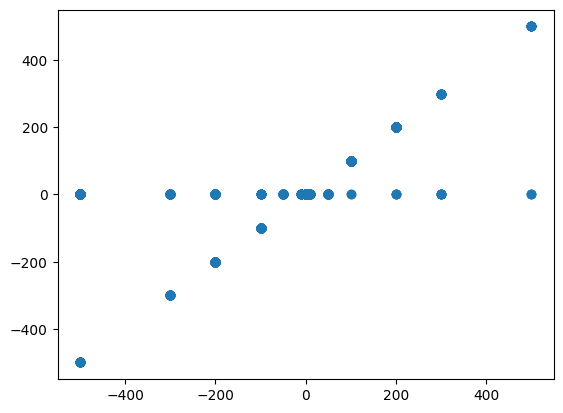

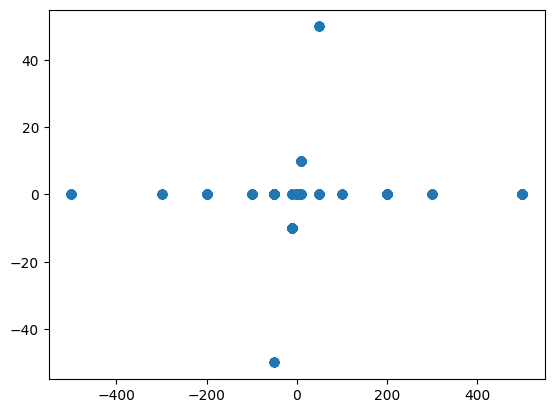

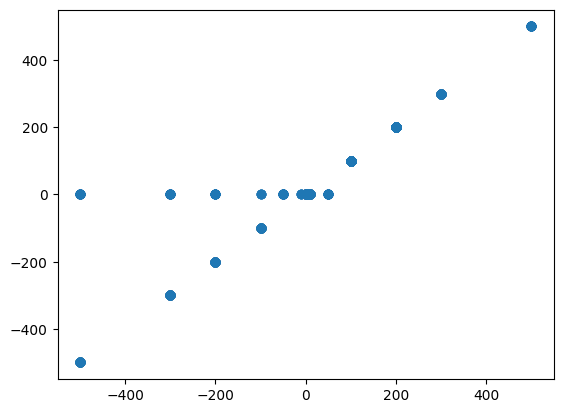

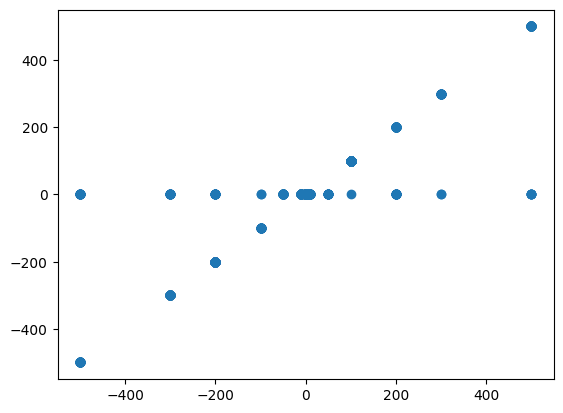

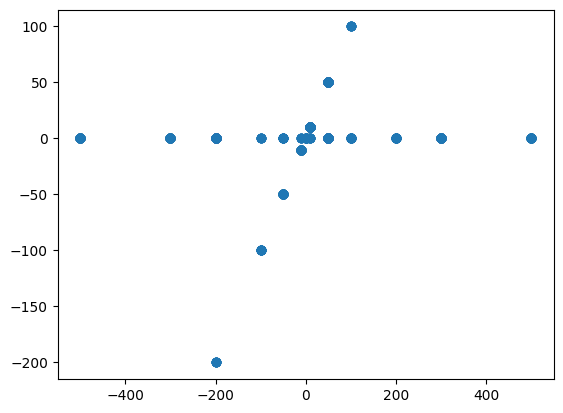

Total value percentage change: 73.04157780713935
PPO: 4584.T profit/loss=11197.034999997442
PPO: 1557.T profit/loss=547040.4899999939
PPO: 8789.T profit/loss=-46588.820000000735
PPO: 1893.T profit/loss=334959.8030422954
PPO: MSFT profit/loss=2255921.8359024837
(RolloutWorker pid=22948) 3


In [8]:
def evaluate(agent, env):
    obs, info = env.reset(seed=42)
    terminated = False

    # Initialize data tracking
    profit_loss = defaultdict(float)
    total_profit_loss = defaultdict(float)
    stock_prices = defaultdict(list)
    transaction_volumes = defaultdict(list)
    portfolio_values = defaultdict(list)
    portfolio_stock_number = defaultdict(list)
    profit_loss_values = defaultdict(list)
    total_values = []

    # Calculate the starting portfolio value
    stocks = env.stock_data.columns
    total_value_start = env.cash + sum(env.positions[stock] * env.stock_data.loc[env.current_step, stock] for stock in stocks)
    total_values.append(total_value_start)
    portfolio_ratios = {stock: [] for stock in stocks}
    portfolio_ratios["cash"] = []

    while not terminated:
        # action = agent.compute_action(obs)
        action = agent.compute_single_action(obs, exploit=True)  # force deterministic actions
        obs, reward, terminated, _, info = env.step(action)

        # Update the profit/loss for each stock
        for i, stock in enumerate(stocks):
            stock_prices[stock].append(env.stock_data.loc[env.current_step, stock])
            transaction_volumes[stock].append(env.shares_amounts[action[i]])
            portfolio_stock_number[stock].append(env.positions[stock])
            current_value = env.positions[stock] * env.stock_data.loc[env.current_step, stock]
            portfolio_values[stock].append(current_value)
            cost = info.get(stock, {}).get('cost', 0)
            sold_value = info.get(stock, {}).get('sell_value', 0)
            profit_loss[stock] += sold_value - cost
            total_profit_loss[stock] = profit_loss[stock] + current_value
            profit_loss_values[stock].append(total_profit_loss[stock])
            
        # Update portfolio ratios
        total_value = env.cash + sum(env.positions[stock] * env.stock_data.loc[env.current_step, stock] for stock in stocks)
        for stock in stocks:
            portfolio_ratios[stock].append(portfolio_values[stock][-1] / total_value)
        portfolio_ratios["cash"].append(env.cash / total_value)


        total_value_end = env.cash + sum(env.positions[stock] * env.stock_data.loc[env.current_step, stock] for stock in stocks)
        total_values.append(total_value_end)

    # Calculate total value percentage change
    total_value_percentage_change = ((total_value_end - total_value_start) / total_value_start) * 100
    total_values_percentage = [(value / total_value_start - 1) * 100 for value in total_values]
    
    # Plot data
    for stock in stocks:
        diff = [0]
        profit = [0]
        for i in range(len(portfolio_stock_number[stock])):
            if i>0:
                diff.append(portfolio_stock_number[stock][i]-portfolio_stock_number[stock][i-1])
                profit.append(profit[i-1]+diff[i]*stock_prices[stock][i])

        plt.scatter(transaction_volumes[stock], diff)
        plt.show()

    return total_value_percentage_change, dict(total_profit_loss)



register_env(env_name, create_stock_trading_env)
ray.init(ignore_reinit_error=True)

# Create the environment
env = StockTradingEnv(stock_data, features)

# Create PPO agent
ppo_config = PPOConfig()
ppo_config["seed"] = 42
ppo_agent = ppo_config.environment(env=env_name)
ppo_agent = ppo_config.build()
# ppo_agent.restore('./model/penalty_dmodel10_scaled_vf001_Wpos')
ppo_agent.restore(modelpath)

print("\nEvaluating trained agents:")
rewards = evaluate(ppo_agent, env)
print(f"Total value percentage change: {rewards[0]}")
for stock, reward in rewards[1].items():
    print(f"PPO: {stock} profit/loss={reward}")


# Shutdown Ray
ray.shutdown()